# Sklearn regression pipeline

In [133]:
import numpy as np
import pandas as pd

from data import train, validation
from data import X, y, numerical, categorical

In [134]:
train.head()

,attribute2,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,meanAge,gender,meanEducation,maritalStatus,plus,...,brandID_33,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,attribute1_2,attribute1_3,attribute1_4
1404,4.850075,3.082306,4.281904,3.791205,6.480146,7.813408,1.380382,11.580054,2.201123,1.650476,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2184,2.910045,0.094506,1.709888,1.637009,0.059201,7.600842,0.000000,10.896544,1.410243,1.856786,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
796,4.850075,0.217541,0.994800,1.103595,0.193577,7.016162,0.849466,11.865126,0.987170,0.866500,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
25,3.880060,0.327738,1.566200,1.306937,0.509315,6.876952,0.000000,10.805739,1.645284,1.624688,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1745,4.850075,0.389791,2.506703,2.351882,0.265934,8.667627,1.162427,11.653248,3.117380,1.476989,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Stage 1: Feature Engineering + Feature Selection
We first use a grid search to consider:
- Power transformations on the response variable
- Adding polynomial terms for predictors 
- Adding interaction terms for predictors
Within each parameter combination, models additionally undergo a backwards variable selection procedure using validation MSE as a metric. 

### Setup for grid search

In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = dict()
param_grid = dict()

### Feature engineering (Preprocessing)

We create a preprocessing pipeline (`preprocessor`) to later embed into the overall model pipeline. The preprocessor is kept seperate so that it can also be transferred to other models.

We consider optionally adding polynomial and interaction terms of up to degree 3 (`PolynomialFeatures`), one of the feature selection steps outlined above, as well as a power transformation (`PowerTransformer`) to normalize the response.

In [136]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures

pipeline['preprocessing'] = Pipeline([
    ('categorical', 'passthrough'),
    ('numerical', ColumnTransformer([
        ('poly', PolynomialFeatures(), numerical),
    ])),
    ('drop', VarianceThreshold()),
])

param_grid['preprocessing'] = {
    'numerical__poly': [
        PolynomialFeatures(degree=3, include_bias=False),
        PolynomialFeatures(degree=2, include_bias=False),
        'passthrough'
    ],
}

### Feature selection

1. RFE (Recursive feature Elimination) removes variables with low coefficients. 
  - O\[k\] at each step, k is number of cross validation folds. 
  - May have trouble finding global optimum. 
  - *Guaranteed* local optimum.

2. Sequential feature selection removes variables by test MSE.
  - O\[kn\] at each step, k is number of cross validation folds, n is number of features.
  - Intuitively feels more likely to find global optimum.
  - However, cannot even guarantee a local optimum without some manual searching.


In [137]:
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

pipeline['dim_reduction'] = Pipeline([
    ('method', 'passthrough'),
])

param_grid['dim_reduction'] = {
    'method': [
        # SequentialFeatureSelector(
        #     estimator = LinearRegression(),
        #     direction = 'backward',
        #     scoring = 'neg_mean_squared_error',
        #     n_jobs=-1,
        # ),
        RFECV(
            estimator = LinearRegression(),
            scoring = 'neg_mean_squared_error',
            # n_jobs=-1,
        ),
        'passthrough',
    ],
}


### Standard OLS model

Having previously noted the non-normal distribution of the response, we consider a standard OLS model with an optional power transformation to normalize the response. 

Regularization will be considered in the next stage once optimal input parameters have been found.

In [138]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.preprocessing import PowerTransformer

pipeline['model_fitting'] = Pipeline([
    ('method', 'passthrough'), # Set in param grid
])

param_grid['model_fitting'] = {
    'method': [
        TweedieRegressor(power=1, max_iter=10000), # Poisson GLM
        TweedieRegressor(power=2, max_iter=10000), # Gamma GLM
        TweedieRegressor(power=3, max_iter=10000), # Inverse Gaussian GLM
        TransformedTargetRegressor(
            regressor = LinearRegression(),
            transformer = PowerTransformer(),
        ),
        LinearRegression(),
    ]
}

### Final Pipeline

In [144]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(
    estimator = Pipeline([
        (name, pipe) 
        for name, pipe in pipeline.items()
    ]),
    param_grid = {
        f'{name}__{param}': value 
        for name, subgrid in param_grid.items()
        for param, value in subgrid.items()
    },
    n_jobs = -1,
    scoring = ['r2', 'neg_mean_squared_error'],
    refit = 'neg_mean_squared_error',
    return_train_score = True,
    verbose = 10,
)

In [145]:
print(80*'=')
print('Pipeline Structure')
print(80*'-')
print(search.estimator)


Pipeline Structure
--------------------------------------------------------------------------------
Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('categorical', 'passthrough'),
                                 ('numerical',
                                  ColumnTransformer(transformers=[('poly',
                                                                   PolynomialFeatures(),
                                                                   ['attribute2',
                                                                    'clickVolume',
                                                                    'avgOriginalUnitPrice',
                                                                    'avgFinalUnitPrice',
                                                                    'ma14SalesVolume',
                                                                    'meanAge',
                                                                    'gender',


In [146]:
print(80*'=')
print('Parameter Space')
print(80*'-')
for param, values in search.param_grid.items():
    print(param)
    for value in values:
        print('-', value)
    print()

Parameter Space
--------------------------------------------------------------------------------
preprocessing__numerical__poly
- PolynomialFeatures(degree=3, include_bias=False)
- PolynomialFeatures(include_bias=False)
- passthrough

dim_reduction__method
- RFECV(estimator=LinearRegression(), n_jobs=-1, scoring='neg_mean_squared_error')
- passthrough

model_fitting__method
- TweedieRegressor(max_iter=10000, power=1)
- TweedieRegressor(max_iter=10000, power=2)
- TweedieRegressor(max_iter=10000, power=3)
- TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=PowerTransformer())
- LinearRegression()



### Grid Search

In [148]:
import pickle 

search.fit(train[X], train[y])

Save results
with open('models/regression_phase_1.p', 'wb') as f:
    pickle.dump(search, f)

In [256]:
with open('models/regression_phase_1.p', 'rb') as f:
    search = pickle.load(f)

In [257]:
def cv_results_to_df(results):
    results = results.copy()
    params = pd.DataFrame(results.pop('params'))
    values = pd.DataFrame(results)
    values = values.loc[:, ~values.columns.str.contains('param_')]
    columns = [
        'mean_train_neg_mean_squared_error',
        'mean_test_neg_mean_squared_error',
    ]
    columns = columns + [col for col in values.columns if col not in columns]
    df = pd.concat([params, values[columns]], axis=1)
    df = df.set_index(list(params.columns))
    df = df.sort_values('rank_test_neg_mean_squared_error')
    return df

results = cv_results_to_df(search.cv_results_)
results.head()

mean_fit_time  \
dim_reduction__method                              model_fitting__method preprocessing__numerical__poly                                    
passthrough                                        LinearRegression()    PolynomialFeatures(include_bias=False)                 0.030986   
                                                                         passthrough                                            0.014525   
RFECV(estimator=LinearRegression(), n_jobs=-1, ... LinearRegression()    passthrough                                            0.308850   
                                                                         PolynomialFeatures(include_bias=False)                 4.375431   
                                                                         PolynomialFeatures(degree=3, include_bias=False)     248.595234   

                                                                                                                           std_fit_time  \
dim_reduction__method                              model_fitting__method preprocessing__numerical__poly                                   
passthrough                                        LinearRegression()    PolynomialFeatures(include_bias=False)                0.003232   
                                                                         passthrough                                           0.006030   
RFECV(estimator=LinearRegression(), n_jobs=-1, ... LinearRegression()    passthrough                                           0.024088   
                                                                         PolynomialFeatures(include_bias=False)                0.109514   
                                                                         PolynomialFeatures(degree=3, include_bias=False)     74.109228   

                                                                                                                           mean_score_time  \
dim_reduction__method                              model_fitting__method preprocessing__numerical__poly                                      
passthrough                                        LinearRegression()    PolynomialFeatures(include_bias=False)                   0.008011   
                                                                         passthrough                                              0.004306   
RFECV(estimator=LinearRegression(), n_jobs=-1, ... LinearRegression()    passthrough                                              0.006963   
                                                                         PolynomialFeatures(include_bias=False)                   0.011789   
                                                                         PolynomialFeatures(degree=3, include_bias=False)         0.011351   

                                                                                                                           std_score_time  \
dim_reduction__method                              model_fitting__method preprocessing__numerical__poly                                     
passthrough                                        LinearRegression()    PolynomialFeatures(include_bias=False)                  0.000593   
                                                                         passthrough                                             0.000177   
RFECV(estimator=LinearRegression(), n_jobs=-1, ... LinearRegression()    passthrough                                             0.002840   
                                                                         PolynomialFeatures(include_bias=False)                  0.006342   
                                                                         PolynomialFeatures(degree=3, include_bias=False)        0.005716   

                                                                                                                           split0_test_r2  \
dim_reduction__method                       

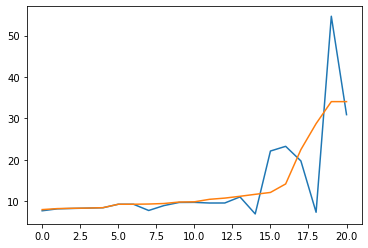

In [258]:
import matplotlib.pyplot as plt

plt.plot(np.log(-results['mean_train_neg_mean_squared_error'].values))
plt.plot(np.log(-results['mean_test_neg_mean_squared_error'].values))
# , 'mean_test_neg_mean_squared_error']].plot()

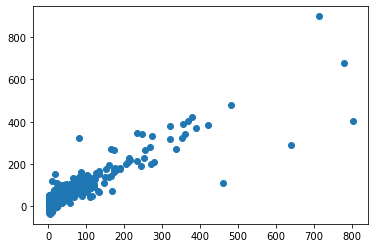

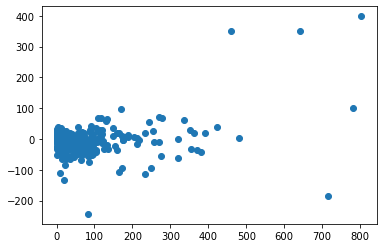

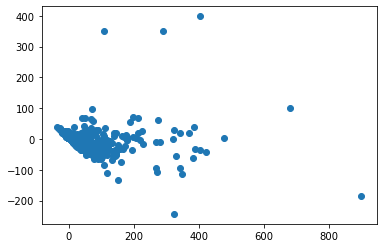

In [259]:
search.best_estimator_.fit(train[X], train[y])

y_true = validation[y]
y_pred = search.best_estimator_.predict(validation[X])
errors = y_true - y_pred

plt.scatter(y_true, y_pred)
plt.show()

plt.scatter(y_true, errors)
plt.show()

plt.scatter(y_pred, errors)
plt.show()

In [260]:
np.mean(np.square(errors))

1672.317975040115

### Stage 2: Model regularization
Model inputs are now fixed and we consider usign a mix of L1 and L2 regularization (ElasticNet) to finely control the strength of the penalty for large coefficients. The best set of regularization parameters are obtained through a grid search.

In [261]:
with open('models/regression_phase_1.p', 'rb') as f:
    search = pickle.load(f)
    best_model = search.best_estimator_

In [262]:
from sklearn.linear_model import ElasticNet

best_model = best_model.set_params(model_fitting__method=ElasticNet(selection='random', max_iter=100000))

In [267]:
search = GridSearchCV(
    estimator = best_model,
    param_grid = {
        'model_fitting__method__alpha': np.logspace(-5, 4, 10),
        'model_fitting__method__l1_ratio': np.logspace(-9, 0, 10),
    },
    n_jobs = -1,
    scoring = ['r2', 'neg_mean_squared_error'],
    refit = 'neg_mean_squared_error',
    return_train_score = True,
    verbose = 10,
)

search.fit(train[X], train[y])

with open('models/regression_phase_2.p', 'wb') as f:
    pickle.dump(search, f)

mean_train_neg_mean_squared_error  \
model_fitting__method__alpha model_fitting__method__l1_ratio                                      
0.1                          1.000000e-09                                          -2223.128225   
                             1.000000e-08                                          -2223.128224   
                             1.000000e-07                                          -2223.128220   
                             1.000000e-06                                          -2223.128176   
                             1.000000e-05                                          -2223.127737   

                                                              mean_test_neg_mean_squared_error  \
model_fitting__method__alpha model_fitting__method__l1_ratio                                     
0.1                          1.000000e-09                                         -2551.579737   
                             1.000000e-08                                         -2551.579737   
                             1.000000e-07                                         -2551.579739   
                             1.000000e-06                                         -2551.579753   
                             1.000000e-05                                         -2551.579892   

                                                              mean_fit_time  \
model_fitting__method__alpha model_fitting__method__l1_ratio                  
0.1                          1.000000e-09                         11.230492   
                             1.000000e-08                          9.744525   
                             1.000000e-07                          8.657083   
                             1.000000e-06                          8.293320   
                             1.000000e-05                          7.373697   

                                                              std_fit_time  \
model_fitting__method__alpha model_fitting__method__l1_ratio                 
0.1                          1.000000e-09                         0.520261   
                             1.000000e-08                         0.296393   
                             1.000000e-07                         0.436664   
                             1.000000e-06                         0.325039   
                             1.000000e-05                         0.499784   

                                                              mean_score_time  \
model_fitting__method__alpha model_fitting__method__l1_ratio                    
0.1                          1.000000e-09                            0.009015   
                             1.000000e-08                            0.009272   
                             1.000000e-07                            0.013761   
                             1.000000e-06                            0.009668   
                             1.000000e-05                            0.009302   

                                                              std_score_time  \
model_fitting__method__alpha model_fitting__method__l1_ratio                   
0.1                          1.000000e-09                           0.000330   
                             1.000000e-08                           0.000751   
                             1.000000e-07                           0.006522   
                             1.000000e-06                           0.001090   
                             1.000000e-05                           0.001328   

                                                              split0_test_r2  \
model_fitting__method__alpha model_fitting__method__l1_ratio                   
0.1                          1.000000e-09                           0.876973   
                             1.000000e-08                           0.876973   
                             1.000000e-07                           0.876973   
                             1.000000e-06          

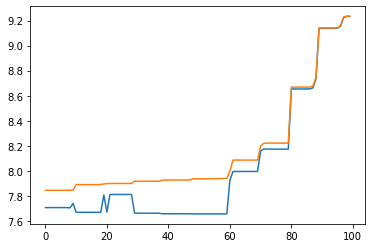

In [264]:
results = cv_results_to_df(search.cv_results_)

plt.plot(np.log(-results['mean_train_neg_mean_squared_error'].values))
plt.plot(np.log(-results['mean_test_neg_mean_squared_error'].values))

results.head()

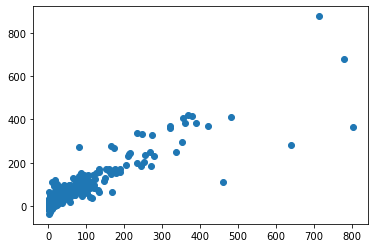

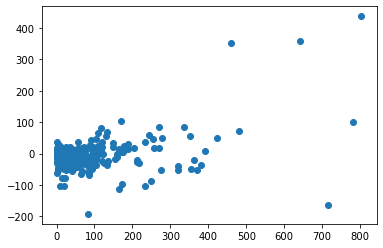

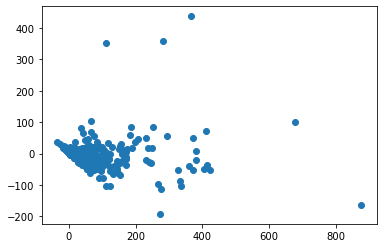

In [265]:
search.best_estimator_.fit(train[X], train[y])

y_true = validation[y]
y_pred = search.best_estimator_.predict(validation[X])
errors = y_true - y_pred

plt.scatter(y_true, y_pred)
plt.show()

plt.scatter(y_true, errors)
plt.show()

plt.scatter(y_pred, errors)
plt.show()

In [266]:
np.mean(np.square(errors))

1669.662809358005